In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import util
from pathlib import Path
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from class_manipulates_path import ManipulatePath
from class_preprocessing_refactor import Preprocessing
from class_format_data import FormatData
util.init()

'Módulo util importado com sucesso.'

In [2]:
def plot_variable(df, column_name):
    """
    Plota um gráfico de dispersão para uma variável de um DataFrame.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - column_name: Nome da coluna que você deseja plotar.
        - intervalos: Lista de intervalos para plotar linhas verticais.
    """
    plt.figure(figsize=(20, 10))
    plt.scatter(df.index.values, df[column_name].values, color='darkcyan', alpha=0.5)
    plt.xlabel('Índice')
    plt.ylabel(column_name)
    plt.title(f'Gráfico de dispersão para a variável "{column_name}"')

    plt.show()

In [3]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [84]:
def plot_two_variables(df, var1, var2, binary_column=None, svg_name="teste.svg"):
    """
    Plota um gráfico de dispersão para duas variáveis de um DataFrame, colorindo os pontos conforme uma coluna binária, se fornecida.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - var1: Nome da primeira variável (eixo x).
        - var2: Nome da segunda variável (eixo y).
        - binary_column: Nome da coluna binária usada para colorir os pontos (opcional).
    """
    plt.figure(figsize=(10, 6))

    if binary_column is not None:
        # Obtendo os valores únicos da coluna binária
        classes = df[binary_column].unique()

        # Criando um mapeamento de classe para cor
        colors = {cls: plt.cm.tab10(i) for i, cls in enumerate(classes)}

        # Colorindo os pontos de acordo com as classes
        for cls in classes:
            df_cls = df[df[binary_column] == cls]
            plt.scatter(df_cls[var1], df_cls[var2], color=colors[cls], label=cls, alpha=0.5)
        
        plt.legend(title="Grupos")
    else:
        plt.scatter(df[var1], df[var2], alpha=0.5)

    plt.xlabel("Primeira componente")
    plt.ylabel("Segunda componente")
    #plt.title(f'Gráfico de Dispersão: {var1} vs {var2}')
    plt.grid(True)
    plt.savefig(svg_name, format='svg')
    plt.show()

In [5]:
def plot_variavel_e_histograma(dataframe, nome_coluna):
    # Verifica se a coluna existe no DataFrame
    if nome_coluna not in dataframe.columns:
        print("A coluna especificada não existe no DataFrame.")
        return
    
    # Plota a variável ao longo do tempo
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    dataframe[nome_coluna].plot()
    plt.title("Variação ao longo do tempo")
    plt.xlabel("Índice")
    plt.ylabel(nome_coluna)
    
    # Plota o histograma da variável
    plt.subplot(1, 2, 2)
    dataframe[nome_coluna].hist()
    plt.title("Histograma")
    plt.xlabel(nome_coluna)
    plt.ylabel("Frequência")
    
    plt.tight_layout()
    plt.show()

In [6]:
def kmeans_two_variables(df, var1, var2, n_clusters=3):
    """
    Aplica o algoritmo K-means para agrupar duas variáveis de um DataFrame.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - var1: Nome da primeira variável.
        - var2: Nome da segunda variável.
        - n_clusters: Número de clusters (padrão é 3).
    """
    # Seleciona as duas variáveis
    X = df[[var1, var2]]

    # Aplica o algoritmo K-means
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)

    # Obtém as coordenadas dos centroides
    centroids = kmeans.cluster_centers_

    # Plota os pontos e os centroides
    plt.figure(figsize=(10, 6))
    plt.scatter(X[var1], X[var2], c=kmeans.labels_, cmap='viridis', alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, color='red')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'K-means: {var1} vs {var2}')
    plt.grid(True)
    plt.show()

In [7]:
def extract_well_number(path):
    match = re.search(r'WELL-(\d+)_', path)
    if match:
        return match.group(1)
    else:
        return None

In [8]:
manipulate_path = ManipulatePath()

preprocessing = Preprocessing()

format_data = FormatData()

path_raw_data = manipulate_path.get_path_raw_data()

In [9]:
df_preprocessing = pd.read_parquet(manipulate_path.get_path_preprocessing_real_data_all_classes())

In [10]:
columns_poly = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']

In [11]:
def polynomial_features(df, columns):
    df_data = df.copy()
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_features = poly.fit_transform(df_data[columns])
    feature_names = poly.get_feature_names_out(input_features=columns)
    df_poly = pd.DataFrame(poly_features, columns=feature_names, index=df_data.index)
    df_poly = df_poly.drop(columns=columns)
    df = pd.concat([df, df_poly],axis=1)
    return df

In [12]:
#df_preprocessing = polynomial_features(df_preprocessing.copy(), columns_poly)

In [13]:
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
timestamp,,,,,
2014-01-24 09:33:03,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:04,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:05,18433410.0,116.8718,9397032.0,74.80031,0.0
2014-01-24 09:33:06,18433410.0,116.8718,9397033.0,74.80031,0.0
2014-01-24 09:33:07,18433410.0,116.8718,9397033.0,74.80031,0.0
...,...,...,...,...,...
2019-04-03 14:59:56,8489354.0,109.7213,1496222.0,73.38219,7.0
2019-04-03 14:59:57,8489349.0,109.7212,1495828.0,73.38310,7.0
2019-04-03 14:59:58,8489344.0,109.7210,1495433.0,73.38401,7.0


In [14]:
def calcular_estatisticas_janela_otimizado(df, column_name, window_size):
    # Calcular os índices de início e fim da janela para cada linha
    indices_inicio_janela = np.arange(len(df) - window_size + 1)
    indices_fim_janela = indices_inicio_janela + window_size
    
    # Calcular as estatísticas para cada janela de uma vez
    min_values = df[column_name].rolling(window=window_size, min_periods=1).min().iloc[indices_fim_janela - 1].values
    max_values = df[column_name].rolling(window=window_size, min_periods=1).max().iloc[indices_fim_janela - 1].values
    mean_values = df[column_name].rolling(window=window_size, min_periods=1).mean().iloc[indices_fim_janela - 1].values
    
    # Criar um novo DataFrame com as estatísticas calculadas
    df_resultado = df.copy()
    df_resultado[f'{column_name}_min'] = np.nan
    df_resultado[f'{column_name}_max'] = np.nan
    df_resultado[f'{column_name}_mean'] = np.nan
    
    df_resultado.iloc[window_size - 1:, df_resultado.columns.get_loc(f'{column_name}_min')] = min_values
    df_resultado.iloc[window_size - 1:, df_resultado.columns.get_loc(f'{column_name}_max')] = max_values
    df_resultado.iloc[window_size - 1:, df_resultado.columns.get_loc(f'{column_name}_mean')] = mean_values
    
    return df_resultado

In [15]:
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
timestamp,,,,,
2014-01-24 09:33:03,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:04,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:05,18433410.0,116.8718,9397032.0,74.80031,0.0
2014-01-24 09:33:06,18433410.0,116.8718,9397033.0,74.80031,0.0
2014-01-24 09:33:07,18433410.0,116.8718,9397033.0,74.80031,0.0
...,...,...,...,...,...
2019-04-03 14:59:56,8489354.0,109.7213,1496222.0,73.38219,7.0
2019-04-03 14:59:57,8489349.0,109.7212,1495828.0,73.38310,7.0
2019-04-03 14:59:58,8489344.0,109.7210,1495433.0,73.38401,7.0


In [16]:
df_preprocessing.columns

Index(['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class'], dtype='object')

In [17]:
# df_preprocessing = calcular_estatisticas_janela_otimizado(df_preprocessing.copy(), "T-TPT", 180)
# df_preprocessing = calcular_estatisticas_janela_otimizado(df_preprocessing.copy(), 'P-TPT', 180)
# df_preprocessing = calcular_estatisticas_janela_otimizado(df_preprocessing.copy(), 'T-JUS-CKP', 180)

In [18]:
def atrasar_variavel(df, column_name, window_size):
    df_resultado = df.copy()
    
    # Renomear a coluna alvo
    df_resultado.rename(columns={column_name: f'{column_name} (t)'}, inplace=True)
    
    # Atrasar a variável em uma janela de tamanho window_size
    for i in range(1, window_size + 1):
        df_resultado[f'{column_name} (t-{i})'] = df[column_name].shift(i)
    
    return df_resultado


In [19]:
#df_preprocessing = atrasar_variavel(df_preprocessing.copy(), "T-TPT", 180)
#df_preprocessing = atrasar_variavel(df_preprocessing.copy(), "P-TPT", 180)
#df_preprocessing = atrasar_variavel(df_preprocessing.copy(), "T-JUS-CKP", 180)

In [20]:
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
timestamp,,,,,
2014-01-24 09:33:03,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:04,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:05,18433410.0,116.8718,9397032.0,74.80031,0.0
2014-01-24 09:33:06,18433410.0,116.8718,9397033.0,74.80031,0.0
2014-01-24 09:33:07,18433410.0,116.8718,9397033.0,74.80031,0.0
...,...,...,...,...,...
2019-04-03 14:59:56,8489354.0,109.7213,1496222.0,73.38219,7.0
2019-04-03 14:59:57,8489349.0,109.7212,1495828.0,73.38310,7.0
2019-04-03 14:59:58,8489344.0,109.7210,1495433.0,73.38401,7.0


In [21]:
df_preprocessing = df_preprocessing.dropna()

In [22]:
df_preprocessing.shape

(977733, 5)

In [23]:
contagem_classes = df_preprocessing['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_preprocessing) * 100
porcentagem_classes

class
0.0    32.679781
5.0    30.983203
7.0    29.009351
1.0     4.797527
6.0     1.810310
2.0     0.719828
Name: count, dtype: float64

In [24]:
#df_preprocessing["class"] = df_preprocessing["class"].replace(101, 1)

In [25]:
contagem_classes = df_preprocessing['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_preprocessing) * 100
porcentagem_classes

class
0.0    32.679781
5.0    30.983203
7.0    29.009351
1.0     4.797527
6.0     1.810310
2.0     0.719828
Name: count, dtype: float64

In [26]:
df_preprocessing.columns

Index(['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class'], dtype='object')

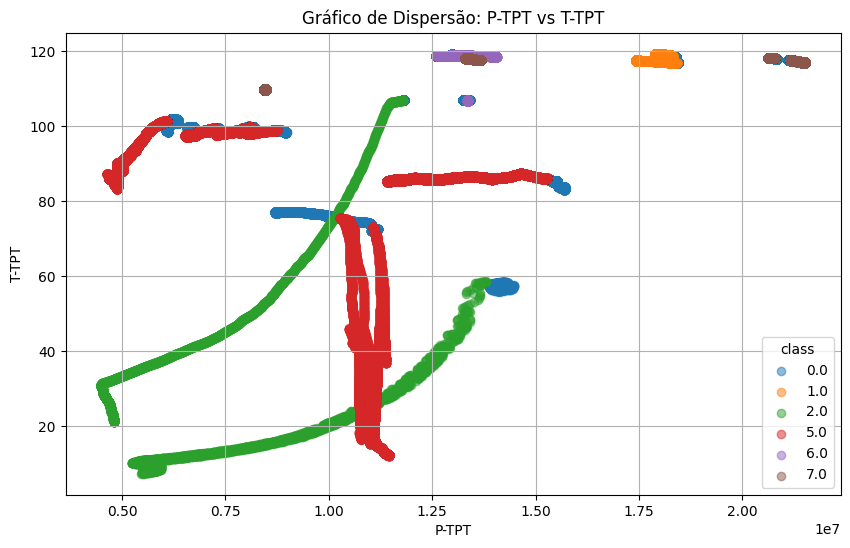

In [27]:
plot_two_variables(df_preprocessing, 'P-TPT', 'T-TPT', binary_column="class")

In [28]:
def kmeans_six_variables(X_pca, n_clusters=3):
    """
    Aplica o algoritmo K-means para agrupar seis variáveis de um DataFrame após a redução de dimensionalidade com PCA.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - n_clusters: Número de clusters (padrão é 3).
    """
    # Aplica PCA para reduzir a dimensionalidade para 2 componentes
    # Aplica o algoritmo K-means
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_pca)

    # Plota os grupos
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, color='red')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('K-means Clustering após Redução de Dimensionalidade')
    plt.grid(True)
    plt.show()

c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


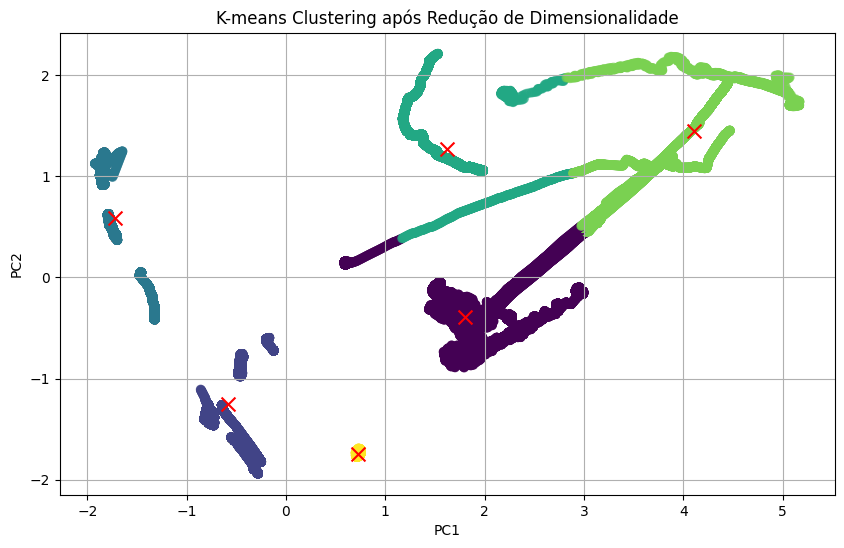

In [29]:
n_components = 2
pca = PCA(n_components=n_components)
scaler = StandardScaler()
X = scaler.fit_transform(df_preprocessing.drop(columns="class"))
X_pca = pca.fit_transform(X)
kmeans_six_variables(X_pca, n_clusters=6)

In [30]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

In [31]:
cumulative_explained_variance

array([0.65918314, 0.91280914])

In [32]:
list_comp = [f"COMP_{x+1}"  for x in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=list_comp)
df_pca["class"] = df_preprocessing["class"].values

In [33]:
# df_test = pd.DataFrame(X, columns=["A","B", "C", "D"])
# df_test["class"] = df_preprocessing["class"].values
# plot_two_variables(df_test, 'A', 'B', binary_column="class")

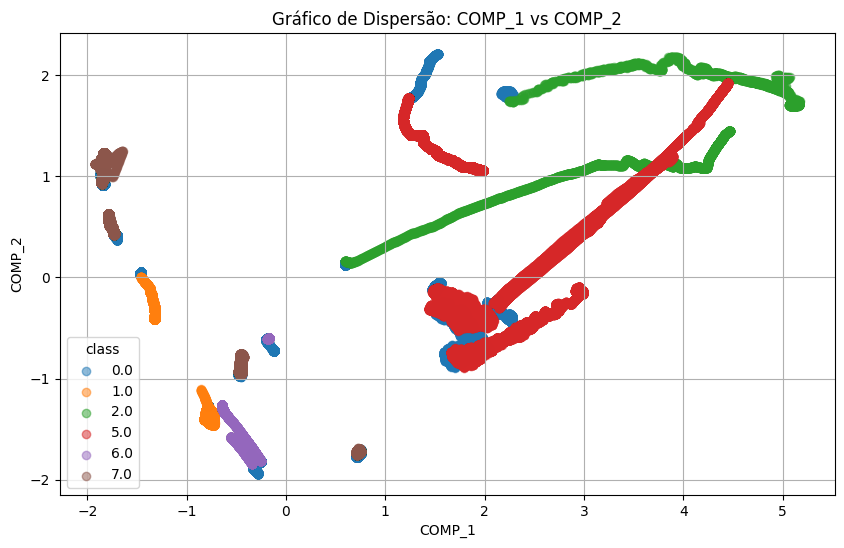

In [34]:
plot_two_variables(df_pca, 'COMP_1', 'COMP_2', binary_column="class")

In [35]:
# chunk_size = len(df_pca) // 3
# 
# # Dividir o dataframe em três pedaços
# df1 = df_pca.iloc[:chunk_size]
# df2 = df_pca.iloc[chunk_size:2*chunk_size]
# df3 = df_pca.iloc[2*chunk_size:]
# 
# # Se houver algum restante, adicioná-lo ao último pedaço
# if len(df_pca) % 3 != 0:
#     df3 = df_pca.iloc[2*chunk_size:]

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [37]:
def split_dataframe(df, target_column=None, test_size=0.0003, random_state=42):
    if target_column:
        # Se a coluna alvo for fornecida, realizar a divisão estratificada
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        for train_index, test_index in split.split(df, df[target_column]):
            df_1 = df.iloc[train_index]
            df_2 = df.iloc[test_index]
    else:
        # Se a coluna alvo não for fornecida, realizar a divisão simples
        df_1, df_2 = train_test_split(df, test_size=test_size, random_state=random_state)

    return df_1, df_2

In [38]:
df_1, df_2 = split_dataframe(df_pca, target_column='class')

In [39]:
df_1

,COMP_1,COMP_2,class
177248,-1.708124,0.414847,0.0
880081,-1.839483,1.000664,7.0
283537,1.519297,1.238628,5.0
205226,5.112105,1.704171,2.0
751537,-1.769870,0.519801,7.0
...,...,...,...
741022,-1.760320,0.516762,7.0
370729,1.495469,-0.079950,0.0
608766,-0.638563,-1.299562,6.0
766761,-1.775695,0.545035,7.0


In [40]:
df_2

,COMP_1,COMP_2,class
432982,1.731880,-0.272237,5.0
507885,1.672102,-0.742712,0.0
11534,-1.459973,0.049190,0.0
247867,1.230394,1.438458,5.0
724323,-1.749528,0.490369,7.0
...,...,...,...
125320,-0.798599,-1.310914,1.0
266112,1.400642,1.313593,5.0
129686,-0.804513,-1.329748,1.0
56216,-1.324189,-0.410967,1.0


# Teste com apenas 300 registros

In [91]:
df_2.sort_values(by="class", inplace=True)

C:\Users\marce\AppData\Local\Temp\ipykernel_8464\3325897059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.sort_values(by="class", inplace=True)


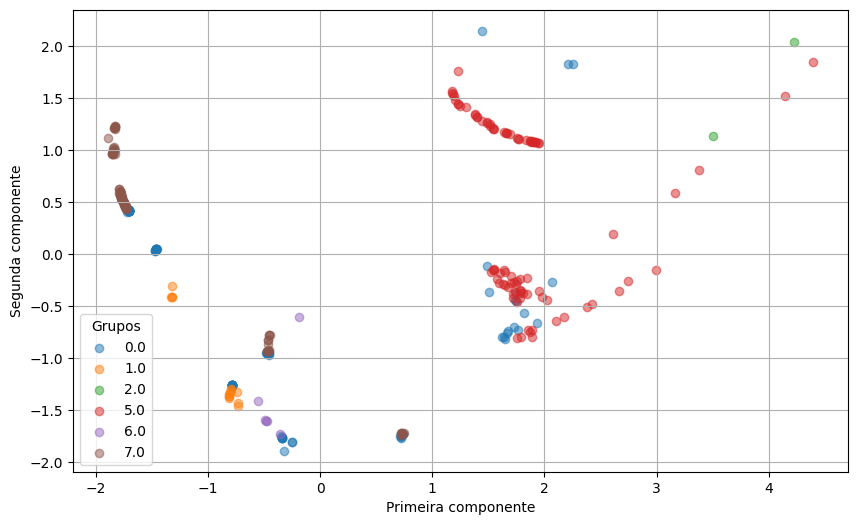

In [92]:
plot_two_variables(df_2, 'COMP_1', 'COMP_2', binary_column="class", svg_name="comp_target_real.svg")

In [43]:
def grid_search_dbscan(X, eps_values, min_samples_values):
    """
    Realiza uma busca em grade para encontrar os melhores valores de eps e min_samples para o DBSCAN.

    Parâmetros:
        - X: Matriz de features.
        - eps_values: Lista de valores para o parâmetro eps.
        - min_samples_values: Lista de valores para o parâmetro min_samples.

    Retorna:
        - Melhores valores de eps e min_samples.
    """
    best_eps = None
    best_min_samples = None
    best_score = -1

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
            labels = dbscan.fit_predict(X)
            unique_labels = np.unique(labels)
            if len(unique_labels) > 1:  # Verifica se há mais de um cluster
                score = silhouette_score(X, labels)
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    return best_eps, best_min_samples

# Exemplo de uso:
# Supondo que 'X' seja a sua matriz de features e 'eps_values' e 'min_samples_values' sejam as listas de valores para os parâmetros
best_eps, best_min_samples = grid_search_dbscan(df_2.drop(columns=["class"]), eps_values=[0.01, 0.1, 0.5, 1.0], min_samples_values=[2, 5, 10])

In [45]:
best_eps

0.5

In [46]:
best_min_samples

5

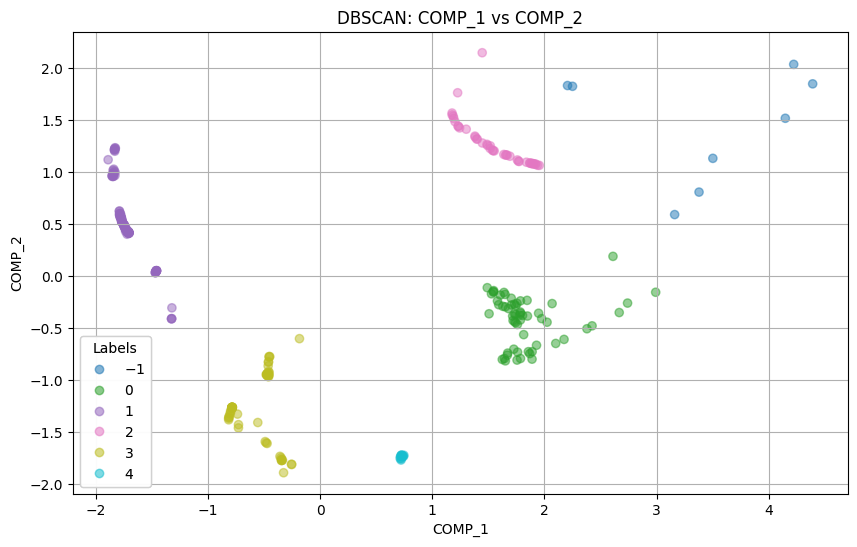

In [50]:
# Aplica o algoritmo DBSCAN
eps=best_eps
min_samples=best_min_samples
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(df_2.drop(columns=["class"]))

# Plota os pontos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_2["COMP_1"], df_2["COMP_2"], c=dbscan.labels_, cmap='tab10', alpha=0.5)
plt.xlabel("COMP_1")
plt.ylabel("COMP_2")
plt.title(f'DBSCAN: {"COMP_1"} vs {"COMP_2"}')
plt.grid(True)

legend1 = plt.legend(*scatter.legend_elements(), title="Labels")
plt.gca().add_artist(legend1)

plt.show()

In [51]:
df_2["class_prev"] = dbscan.labels_

C:\Users\marce\AppData\Local\Temp\ipykernel_8464\2251982250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = dbscan.labels_


In [48]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

In [53]:
mapping_class_prev = {
    1: 7,
    3: 1,
    4: 6,
    2: 5,
    0: 0,
    -1: 2,
}

In [54]:
df_2["class_prev"] = df_2["class_prev"].replace(mapping_class_prev)

C:\Users\marce\AppData\Local\Temp\ipykernel_8464\1445420469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = df_2["class_prev"].replace(mapping_class_prev)


In [89]:
df_2.sort_values(by="class_prev", inplace=True)

C:\Users\marce\AppData\Local\Temp\ipykernel_8464\3257131553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.sort_values(by="class_prev", inplace=True)


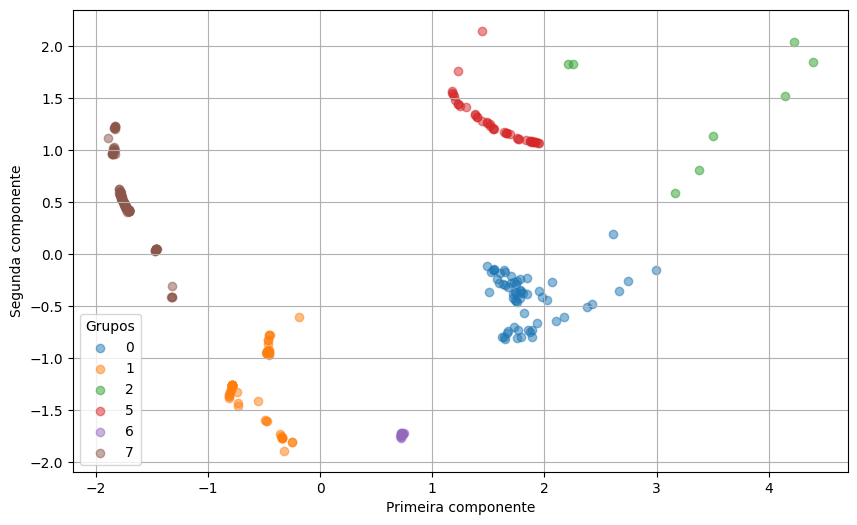

In [90]:
plot_two_variables(df_2, 'COMP_1', 'COMP_2', binary_column="class_prev", svg_name="comp_target_agrupado.svg")

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Supondo que 'y_true' seja a lista/array com os rótulos verdadeiros e 'y_pred' os rótulos previstos pelo seu modelo
accuracy = accuracy_score(df_2["class"], df_2['class_prev'])
print("Acurácia:", accuracy)

Acurácia: 0.45918367346938777


In [63]:
precision = precision_score(df_2["class"], df_2['class_prev'].values, average=None)
recall = recall_score(df_2["class"], df_2['class_prev'].values, average=None)
f1 = f1_score(df_2["class"], df_2['class_prev'].values, average=None)

for i in range(len(precision)):
    print(f'Classe {np.unique(df_2["class"])[i]}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1-score: {f1[i]}\n')

Classe 0.0:
Precision: 0.2459016393442623
Recall: 0.15625
F1-score: 0.1910828025477707

Classe 1.0:
Precision: 0.15151515151515152
Recall: 0.7142857142857143
F1-score: 0.25

Classe 2.0:
Precision: 0.25
Recall: 1.0
F1-score: 0.4

Classe 5.0:
Precision: 0.9761904761904762
Recall: 0.45054945054945056
F1-score: 0.6165413533834586

Classe 6.0:
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Classe 7.0:
Precision: 0.6442307692307693
Recall: 0.788235294117647
F1-score: 0.708994708994709



In [60]:
contagem_classes = df_2['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_2) * 100
porcentagem_classes

class
0.0    32.653061
5.0    30.952381
7.0    28.911565
1.0     4.761905
6.0     2.040816
2.0     0.680272
Name: count, dtype: float64

In [64]:
df_processing_1, df_processing_2 = split_dataframe(df_preprocessing, target_column='class')

In [69]:
df_processing_2["class_prev"] = df_2['class_prev'].values

C:\Users\marce\AppData\Local\Temp\ipykernel_8464\800780047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processing_2["class_prev"] = df_2['class_prev'].values


In [70]:
df_processing_2

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,class_prev
timestamp,,,,,,
2014-03-18 08:48:25,7583908.0,98.40878,3261349.0,43.81690,5.0,0
2014-03-19 12:43:55,6337455.0,101.37720,2604916.0,50.60535,0.0,0
2014-01-24 12:45:17,18437220.0,116.87180,9401221.0,74.79038,0.0,7
2014-03-14 22:53:27,14355880.0,86.46021,7123661.0,32.15251,5.0,5
2018-06-18 20:03:04,20647810.0,118.22820,10566870.0,70.51610,7.0,7
...,...,...,...,...,...,...
2017-08-01 14:40:00,18234740.0,118.90300,2512656.0,79.66547,1.0,1
2014-03-15 03:57:32,13765210.0,86.31015,6423888.0,31.33380,5.0,5
2017-08-01 15:52:46,18174060.0,118.98110,2507937.0,80.05676,1.0,1


In [71]:
accuracy = accuracy_score(df_processing_2["class"], df_processing_2['class_prev'])
print("Acurácia:", accuracy)

Acurácia: 0.45918367346938777


In [80]:
df_processing_2

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,class_prev
timestamp,,,,,,
2014-03-18 08:48:25,7583908.0,98.40878,3261349.0,43.81690,5.0,0
2014-03-19 12:43:55,6337455.0,101.37720,2604916.0,50.60535,0.0,0
2014-01-24 12:45:17,18437220.0,116.87180,9401221.0,74.79038,0.0,7
2014-03-14 22:53:27,14355880.0,86.46021,7123661.0,32.15251,5.0,5
2018-06-18 20:03:04,20647810.0,118.22820,10566870.0,70.51610,7.0,7
...,...,...,...,...,...,...
2017-08-01 14:40:00,18234740.0,118.90300,2512656.0,79.66547,1.0,1
2014-03-15 03:57:32,13765210.0,86.31015,6423888.0,31.33380,5.0,5
2017-08-01 15:52:46,18174060.0,118.98110,2507937.0,80.05676,1.0,1


In [81]:
silhouette_score(df_processing_2.drop(columns=["class", "class_prev"]), df_processing_2['class_prev'].values)

0.4451383642847863

In [75]:
grouped = df_processing_2.drop(columns=["class_prev"]).groupby('class')

# Calcular as métricas
metrics = grouped.agg(['mean','std'])
metrics

P-TPT                     T-TPT                P-MON-CKP  \
               mean           std        mean        std          mean   
class                                                                    
0.0    1.500041e+07  4.928366e+06  112.816320  11.642907  5.622483e+06   
1.0    1.790926e+07  2.961931e+05  118.674143   0.735635  3.991665e+06   
2.0    7.859308e+06  2.058380e+06   28.595775  15.476835  3.548119e+06   
5.0    9.910387e+06  3.180078e+06   88.908577  15.516055  4.157510e+06   
6.0    1.324429e+07  1.729864e+05  116.796850   4.879127  3.757855e+06   
7.0    1.890018e+07  4.019317e+06  117.252802   2.289958  9.674479e+06   

                     T-JUS-CKP             
                std       mean        std  
class                                      
0.0    3.383156e+06  69.590077  12.800905  
1.0    2.641681e+06  79.760714   0.939542  
2.0    5.387178e+05  36.142635   8.010169  
5.0    1.914500e+06  37.731756   7.847206  
6.0    1.129872e+06  81.270795   3.943009  
7.0    3.209112e+06  69.435471   3.362830

In [76]:
grouped = df_processing_2.drop(columns=["class"]).groupby('class_prev')

# Calcular as métricas
metrics = grouped.agg(['mean','std'])
metrics

P-TPT                     T-TPT                P-MON-CKP  \
                    mean           std        mean        std          mean   
class_prev                                                                    
0           7.035500e+06  1.216960e+06   97.314182   6.266465  2.754173e+06   
1           1.498328e+07  2.412970e+06  118.276682   1.491301  3.829394e+06   
2           1.101688e+07  2.486632e+06   33.988138  17.764116  2.771516e+06   
5           1.311916e+07  1.160068e+06   86.079623   0.611036  6.046753e+06   
6           8.442883e+06  1.829606e+04  109.801392   0.051318  1.452134e+06   
7           2.045534e+07  1.007588e+06  117.787044   0.493856  1.067491e+07   

                          T-JUS-CKP            
                     std       mean       std  
class_prev                                     
0           7.842189e+05  45.433985  3.872418  
1           1.468861e+06  77.595967  4.024475  
2           2.226097e+06  38.913115  8.301622  
5           9.277913e+05  29.550263  2.391643  
6           3.645016e+04  74.225718  0.334525  
7           1.090911e+06  70.025529  3.716045

# Experimento com 50% dos dados

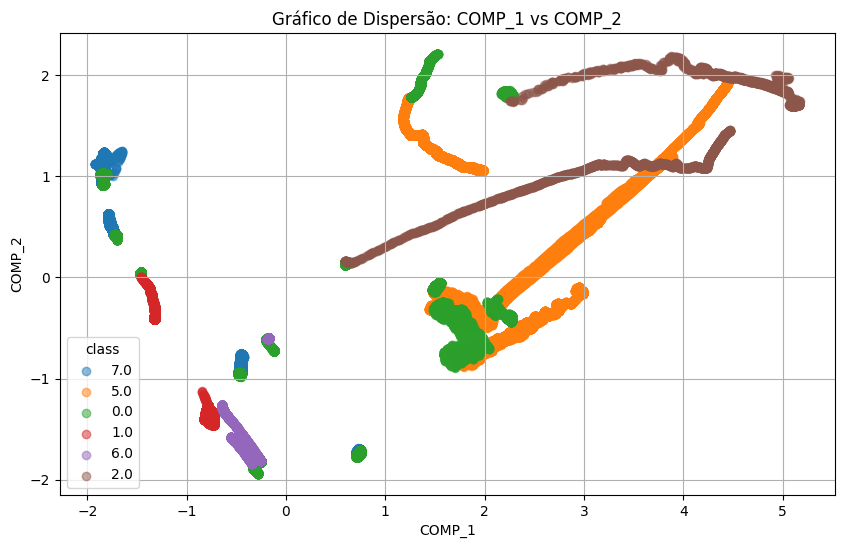

In [53]:
plot_two_variables(df_1, 'COMP_1', 'COMP_2', binary_column="class")

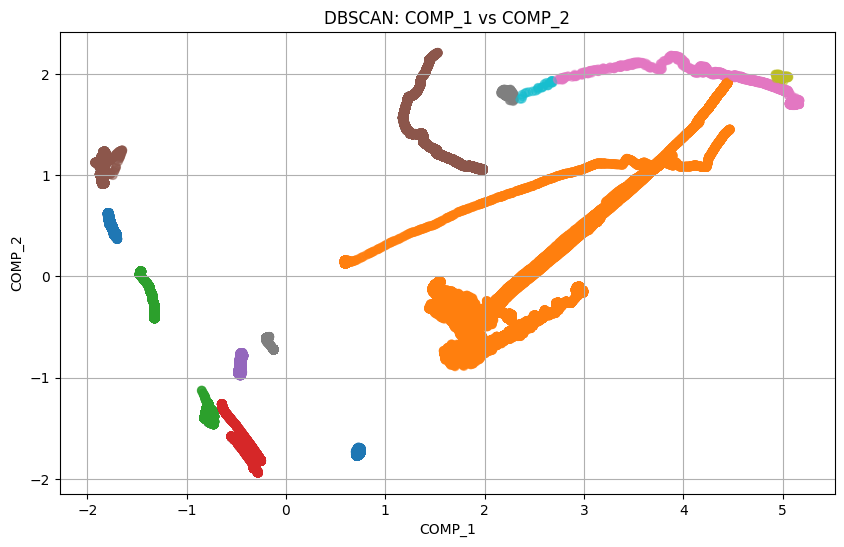

In [54]:
# Aplica o algoritmo DBSCAN
eps=0.05
min_samples=4
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(df_1.drop(columns=["class"]))

# Plota os pontos
plt.figure(figsize=(10, 6))
plt.scatter(df_1["COMP_1"], df_1["COMP_2"], c=dbscan.labels_, cmap='tab10', alpha=0.5)
plt.xlabel("COMP_1")
plt.ylabel("COMP_2")
plt.title(f'DBSCAN: {"COMP_1"} vs {"COMP_2"}')
plt.grid(True)
plt.show()

In [55]:
np.unique(dbscan.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

# Salvando modelo DBSCAM 50% dos dados para não treinar novamente

In [56]:
import dill

In [57]:
file_path = 'modelo_DBSCAN_0_5_V2.dill'

# Salvando o modelo SOM usando dill
with open(file_path, 'wb') as f:
    dill.dump(dbscan, f)

# Daqui para baixo não executei para testar DBSCAN com mais dados

In [ ]:
#segundo teste com min_samples=5
# Aplica o algoritmo DBSCAN
eps=0.05
min_samples=4
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(df_1.drop(columns=["class"]))

# Plota os pontos
plt.figure(figsize=(10, 6))
plt.scatter(df_1["COMP_1"], df_1["COMP_2"], c=dbscan.labels_, cmap='tab10', alpha=0.5)
plt.xlabel("COMP_1")
plt.ylabel("COMP_2")
plt.title(f'DBSCAN: {"COMP_1"} vs {"COMP_2"}')
plt.grid(True)
plt.show()

In [ ]:
colors = {cls: plt.cm.tab10(i) for i, cls in enumerate(np.unique(dbscan.labels_))}

In [45]:
colors

{0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 1: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 2: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 3: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 4: (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 5: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 6: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 7: (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 8: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
 9: (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)}

# Exemplo com 30% dos dados (não salvei esse modelo com DILL)

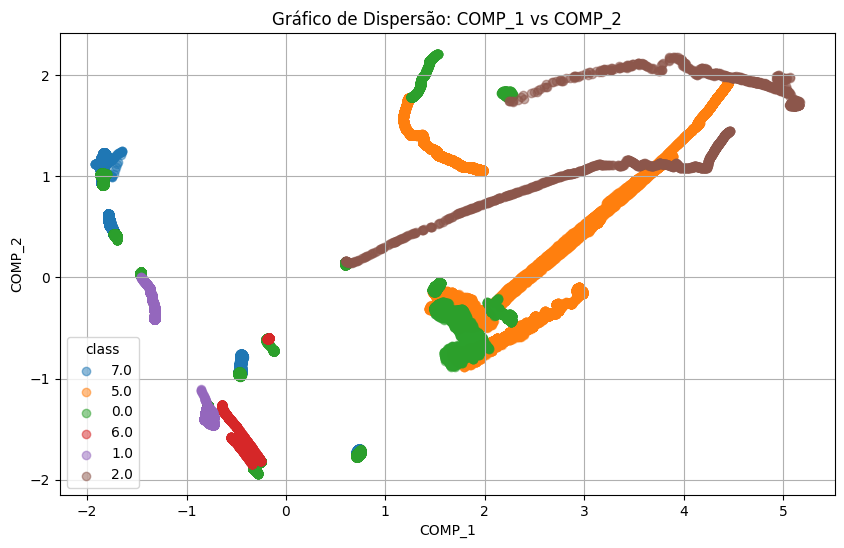

In [40]:
plot_two_variables(df_2, 'COMP_1', 'COMP_2', binary_column="class")

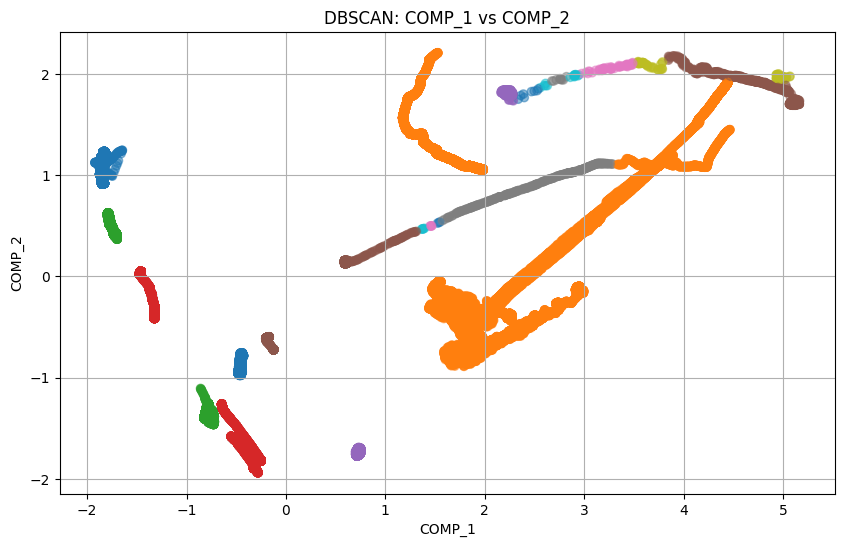

In [48]:
# Aplica o algoritmo DBSCAN
eps=0.05
min_samples=5
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(df_2.drop(columns=["class"]))

# Plota os pontos
plt.figure(figsize=(10, 6))
plt.scatter(df_2["COMP_1"], df_2["COMP_2"], c=dbscan.labels_, cmap='tab10', alpha=0.5)
plt.xlabel("COMP_1")
plt.ylabel("COMP_2")
plt.title(f'DBSCAN: {"COMP_1"} vs {"COMP_2"}')
plt.grid(True)
plt.show()

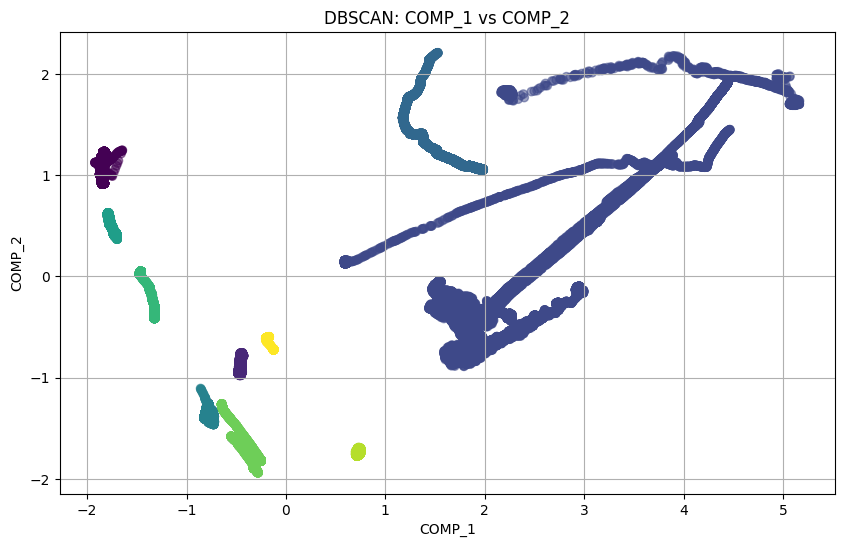

In [42]:
# Aplica o algoritmo DBSCAN
eps=0.1
min_samples=5
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(df_2.drop(columns=["class"]))

# Plota os pontos
plt.figure(figsize=(10, 6))
plt.scatter(df_2["COMP_1"], df_2["COMP_2"], c=dbscan.labels_, cmap='tab10', alpha=0.5)
plt.xlabel("COMP_1")
plt.ylabel("COMP_2")
plt.title(f'DBSCAN: {"COMP_1"} vs {"COMP_2"}')
plt.grid(True)
plt.show()

# Conclusão

- Dividiu bem, mas difícil dizer quem é falha e quem não é